In [95]:
import re
import sys
import os
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy import cluster

from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.signal import find_peaks

import PCprophet.io_ as io
import PCprophet.generate_features_allbyall as gf

In [219]:
infile = "..\\data\\SEC_pilot_HEK\\SEC_pilot_HEK_min_5_frac.txt"
#infile = "..\\test\\test_frac.txt"
prot_dict = io.read_txt(path=infile)


Number of analyzed genes in ..\data\SEC_pilot_HEK\SEC_pilot_HEK_min_5_frac.txt: 6692
Removed 1 empty or invalid keys from prot_dict.


In [220]:
def min_max_scale_prot_dict(prot_dict):
    """
    Apply min/max scaling to the co-elution data in prot_dict.
    
    Parameters:
    - prot_dict: Dictionary where keys are protein names and values are lists/arrays
                 of co-elution intensities.
    
    Returns:
    - scaled_prot_dict: Dictionary with scaled intensities.
    """
    prot_dict_scaled = {}
    
    for protein, intensities in prot_dict.items():
        # Convert intensities to a NumPy array
        intensities = np.array(intensities)
        
        # Min/max scaling
        min_val = np.min(intensities)
        max_val = np.max(intensities)
        if max_val - min_val > 0:  # Avoid division by zero
            scaled_intensities = (intensities - min_val) / (max_val - min_val)
        else:
            # If all values are the same, set them to 0 (or any consistent value)
            scaled_intensities = np.zeros_like(intensities)
        
        # Add scaled values to the new dictionary
        prot_dict_scaled[protein] = scaled_intensities
    
    return prot_dict_scaled

# Outlier detection

Simple z-scoring does not work because an outlier with the same intensitiy as a peak of a chromatogram would have the same z-score as that peak

Idea: 
- look for sharp increases followed by sharp decreases by computing difference between value and previous value and then multiplying neighboring values
- Sharp increases followed by sharp decreases will lead to high negative values -> detect those using z-scoring

Pitfall: 
- This method requires padding the chromatogram -> method is blind to outliers in the first and last fractions

In [237]:
def remove_outliers(prot_dict, threshold):
    """
    Removes all intensity values from prot_dict where the corresponding z_scores_ms < threshold.

    Parameters:
        prot_dict (dict): A dictionary where keys are gene names and values are lists of intensity values.
        threshold (float): The z-score threshold for identifying outliers.

    Returns:
        dict: A dictionary with outliers removed based on the threshold.
    """
    filtered_dict = {}
    
    for gene, intensities in prot_dict.items():
        intensities = np.array(intensities)
        
        # Padding the first and last values
        pad_start = np.concatenate(([intensities[0]], intensities))
        pad_end = np.concatenate((intensities, [intensities[-1]]))

        # Calculate the difference (pad_end - pad_start)
        diff = pad_end - pad_start

        # Combine squared differences of two neighboring points
        ms = np.array([diff[i] * diff[i+1] for i in range(len(diff) - 1)])

        # Calculate mean, standard deviation, and z-scores
        mean_ms = np.mean(ms)
        std_ms = np.std(ms)
        z_scores_ms = (ms - mean_ms) / std_ms

        # Create a mask where z_scores_ms >= threshold
        mask = z_scores_ms >= threshold

        # Apply the mask to filter the original intensities
        filtered_intensities = intensities[mask]

        # Store the filtered intensities in the new dictionary
        filtered_dict[gene] = filtered_intensities.tolist()
    
    return filtered_dict

In [238]:
prot_dict_filtered = remove_outliers(prot_dict, threshold=-7)

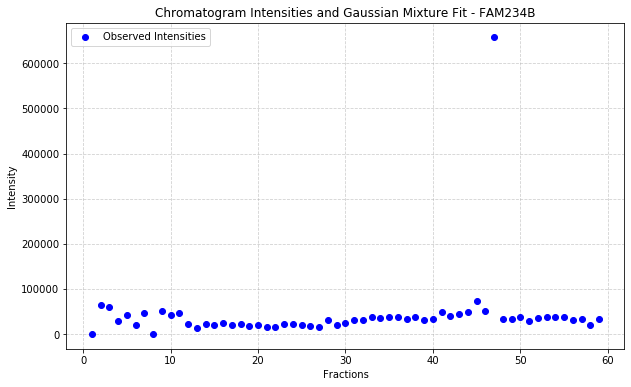

In [239]:
first_protein = list(prot_dict.keys())[5]
fractions = np.arange(1, len(prot_dict[first_protein]) + 1)
intensities = np.array(prot_dict[first_protein])

plt.figure(figsize=(10, 6))

# Plot observed intensities
plt.scatter(fractions, intensities, color='blue', label='Observed Intensities', zorder=5)

# Customize plot
plt.title(f"Chromatogram Intensities and Gaussian Mixture Fit - {first_protein}")
plt.xlabel("Fractions")
plt.ylabel("Intensity")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

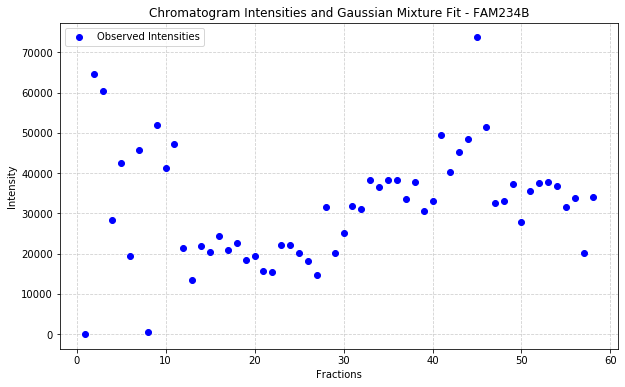

In [240]:
fractions = np.arange(1, len(prot_dict_filtered[first_protein]) + 1)
intensities = np.array(prot_dict_filtered[first_protein])

plt.figure(figsize=(10, 6))

# Plot observed intensities
plt.scatter(fractions, intensities, color='blue', label='Observed Intensities', zorder=5)

# Customize plot
plt.title(f"Chromatogram Intensities and Gaussian Mixture Fit - {first_protein}")
plt.xlabel("Fractions")
plt.ylabel("Intensity")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
prot_dict_smooth = gf.clean_prot_dict(prot_dict)
prot_dict_scaled = min_max_scale_prot_dict(prot_dict=prot_dict_smooth)


# PrInCE - derived python code

In [99]:
def make_initial_conditions(chromatogram, n_gaussians, method="guess", sigma_default=2, sigma_noise=0.5, mu_noise=1.5, A_noise=0.5):
    """
    Generate initial conditions for Gaussian fitting.
    """
    if method == "guess":
        # Identify local maxima
        peaks = (np.diff(np.sign(np.diff(chromatogram))) == -2).nonzero()[0] + 1
        peaks = np.append(peaks, [0, len(chromatogram) - 1])  # Include boundaries
        peaks = peaks[np.argsort(-chromatogram[peaks])]  # Sort by height
        
        # Generate initial conditions
        A = []
        mu = []
        sigma = []
        for i in range(n_gaussians):
            if i < len(peaks):
                A.append(chromatogram[peaks[i]] + np.random.uniform(-A_noise, A_noise))
                mu.append(peaks[i] + np.random.uniform(-mu_noise, mu_noise))
                sigma.append(sigma_default + np.random.uniform(-sigma_noise, sigma_noise))
            else:  # Fill with random values if not enough peaks
                A.append(np.random.uniform(0, max(chromatogram)))
                mu.append(np.random.uniform(0, len(chromatogram)))
                sigma.append(sigma_default + np.random.uniform(-sigma_noise, sigma_noise))
        return {"A": np.array(A), "mu": np.array(mu), "sigma": np.array(sigma)}
    elif method == "random":
        A = np.random.uniform(0, max(chromatogram), n_gaussians)
        mu = np.random.uniform(0, len(chromatogram), n_gaussians)
        sigma = sigma_default + np.random.uniform(-sigma_noise, sigma_noise, n_gaussians)
        return {"A": A, "mu": mu, "sigma": sigma}

def fit_curve(coefs, indices):
    """
    Compute the fitted curve from Gaussian coefficients.
    """
    A = coefs["A"]
    mu = coefs["mu"]
    sigma = coefs["sigma"]
    gaussians = len(A)
    return np.sum([A[i] * np.exp(-((indices - mu[i]) / sigma[i])**2) for i in range(gaussians)], axis=0)

# Define Gaussian mixture model
def gaussian_model(x, *params):
    gaussians = len(params) // 3
    A, mu, sigma = np.split(np.array(params), 3)
    return np.sum([A[i] * np.exp(-((x - mu[i]) / sigma[i])**2) for i in range(gaussians)], axis=0)

def fit_gaussians(chromatogram, n_gaussians, max_iterations, method,
                  filter_gaussians_center, filter_gaussians_height,
                  filter_gaussians_variance_min, filter_gaussians_variance_max):
    """
    Fit a mixture of Gaussians to a chromatogram.
    """
    indices = np.arange(len(chromatogram))
    best_R2 = -np.inf
    best_coefs = None
    
    for _ in range(max_iterations):
        # Generate initial conditions
        init = make_initial_conditions(chromatogram, n_gaussians, method)
        A, mu, sigma = init["A"], init["mu"], init["sigma"]
        
        # Flatten initial parameters
        init_params = np.concatenate([A, mu, sigma])
        
        try:
            # Perform curve fitting
            popt, _ = curve_fit(gaussian_model, indices, chromatogram, p0=init_params, maxfev=5000)

            # Extract fitted coefficients
            coefs = {"A": popt[:n_gaussians], "mu": popt[n_gaussians:2*n_gaussians], "sigma": popt[2*n_gaussians:]}


            # Remove Gaussians with negative or too-small variances
            if filter_gaussians_variance_min > 0:
                valid_indices = coefs["sigma"] >= filter_gaussians_variance_min
                coefs = {
                    "A": coefs["A"][valid_indices],
                    "mu": coefs["mu"][valid_indices],
                    "sigma": coefs["sigma"][valid_indices]
                }
                # Skip if all Gaussians are filtered out
                if len(coefs["A"]) == 0:
                    continue
            
            # Remove Gaussians with extremely large variances
            if filter_gaussians_variance_max > 0:
                valid_indices = coefs["sigma"] <= filter_gaussians_variance_max
                coefs = {
                    "A": coefs["A"][valid_indices],
                    "mu": coefs["mu"][valid_indices],
                    "sigma": coefs["sigma"][valid_indices]
                }
                # Skip if all Gaussians are filtered out
                if len(coefs["A"]) == 0:
                    continue

            # Remove Gaussians with heights less than a specified fraction of max chromatogram intensity
            if filter_gaussians_height > 0:
                min_height = max(chromatogram) * filter_gaussians_height
                valid_indices = coefs["A"] >= min_height
                coefs = {
                    "A": coefs["A"][valid_indices],
                    "mu": coefs["mu"][valid_indices],
                    "sigma": coefs["sigma"][valid_indices]
                }
                if len(coefs["A"]) == 0:
                    continue

            # Remove Gaussians with centers outside chromatogram bounds
            if filter_gaussians_center:
                valid_indices = (coefs["mu"] >= 0) & (coefs["mu"] <= len(chromatogram))
                coefs = {
                    "A": coefs["A"][valid_indices],
                    "mu": coefs["mu"][valid_indices],
                    "sigma": coefs["sigma"][valid_indices]
                }
                if len(coefs["A"]) == 0:
                    continue

            curve_fit_result = fit_curve(coefs, indices)
            
            # Calculate R-squared
            residual = chromatogram - curve_fit_result
            ss_res = np.sum(residual**2)
            ss_tot = np.sum((chromatogram - np.mean(chromatogram))**2)
            R2 = 1 - (ss_res / ss_tot)
            
            if R2 > best_R2:
                best_R2 = R2
                best_coefs = coefs
        except Exception:
            continue
    
    return {"R2": best_R2, "coefs": best_coefs, "fit_curve": fit_curve(best_coefs, indices) if best_coefs else None}


In [100]:
def gaussian_aicc(coefs, chromatogram):
    """
    Calculate the corrected Akaike Information Criterion (AICc).
    """
    n = len(chromatogram)  # Number of data points
    k = len(coefs["A"]) * 3  # Number of parameters (A, mu, sigma for each Gaussian)
    if k >= n - 1:
        return np.inf  # Avoid division by zero or invalid AICc when parameters exceed data points
    
    rss = np.sum((chromatogram - fit_curve(coefs, np.arange(len(chromatogram))))**2)
    aic = n * np.log(rss / n) + 2 * k
    return aic + (2 * k * (k + 1)) / (n - k - 1)

def gaussian_aic(coefs, chromatogram):
    """
    Calculate the Akaike Information Criterion (AIC).
    """
    n = len(chromatogram)  # Number of data points
    k = len(coefs["A"]) * 3  # Number of parameters (A, mu, sigma for each Gaussian)
    rss = np.sum((chromatogram - fit_curve(coefs, np.arange(len(chromatogram))))**2)
    return n * np.log(rss / n) + 2 * k

def gaussian_bic(coefs, chromatogram):
    """
    Calculate the Bayesian Information Criterion (BIC).
    """
    n = len(chromatogram)  # Number of data points
    k = len(coefs["A"]) * 3  # Number of parameters (A, mu, sigma for each Gaussian)
    rss = np.sum((chromatogram - fit_curve(coefs, np.arange(len(chromatogram))))**2)
    return n * np.log(rss / n) + k * np.log(n)

def choose_gaussians(chromatogram, points=None, max_gaussians=5, criterion="BIC",
                     max_iterations=10, method="guess",
                     filter_gaussians_center=True, filter_gaussians_height=0.15,
                     filter_gaussians_variance_min=0.1, filter_gaussians_variance_max=50):
    """
    Fit mixtures of Gaussians to a chromatogram and select the best model using an information criterion.
    """
    # Adjust max_gaussians based on available data points
    if points is not None:
        max_gaussians = min(max_gaussians, points // 3)
    
    # Fit models with increasing numbers of Gaussians
    fits = []
    for n_gaussians in range(1, max_gaussians + 1):
        fit = fit_gaussians(chromatogram, n_gaussians, max_iterations, method,
                            filter_gaussians_center, filter_gaussians_height,
                            filter_gaussians_variance_min, filter_gaussians_variance_max)
        fits.append(fit)
    
    # Remove models that failed to fit
    valid_fits = [fit for fit in fits if fit["coefs"] is not None]
    if not valid_fits:
        return None  # No valid fits
    
    # Calculate the chosen information criterion for each valid fit
    if criterion == "AICc":
        criteria = [gaussian_aicc(fit["coefs"], chromatogram) for fit in valid_fits]
    elif criterion == "AIC":
        criteria = [gaussian_aic(fit["coefs"], chromatogram) for fit in valid_fits]
    elif criterion == "BIC":
        criteria = [gaussian_bic(fit["coefs"], chromatogram) for fit in valid_fits]
    else:
        raise ValueError("Invalid criterion. Choose 'AICc', 'AIC', or 'BIC'.")
    
    # Select the model with the lowest criterion value
    best_fit_index = np.argmin(criteria)
    return valid_fits[best_fit_index]

In [101]:
# Plot the chromatogram intensities, the best-fit Gaussian mixture, and mu positions
def visualize_fit(protein, fractions, intensities, gmm):
    """
    Visualize chromatogram intensities, the best-fit Gaussian mixture, and mu positions.

    Parameters:
    - fractions: Array of fraction indices (x-axis).
    - intensities: Array of observed chromatogram intensities (y-axis).
    - gmm: Output from fit_gaussians() containing the best fit and coefficients.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot observed intensities
    plt.scatter(fractions, intensities, color='blue', label='Observed Intensities', zorder=5)
    
    # Plot the best-fit Gaussian mixture
    if gmm["fit_curve"] is not None:
        plt.plot(fractions, gmm["fit_curve"], color='red', lw=2, label='Best-Fit Gaussian Mixture')
        
        # Plot vertical lines at mu positions
        mu_positions = gmm["coefs"]["mu"]
        for i, mu in enumerate(mu_positions):
            # Add label only to the first line to avoid duplicate legend entries
            if i == 0:
                plt.axvline(x=mu, color='green', linestyle='--', alpha=0.7, label='Gaussian Centers (mu)')
            else:
                plt.axvline(x=mu, color='green', linestyle='--', alpha=0.7)
    else:
        plt.text(0.5, 0.5, "No valid Gaussian fit found", fontsize=12, ha="center", transform=plt.gca().transAxes)
    
    # Customize plot
    plt.title(f"Chromatogram Intensities and Gaussian Mixture Fit - {protein}")
    plt.xlabel("Fractions")
    plt.ylabel("Intensity")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

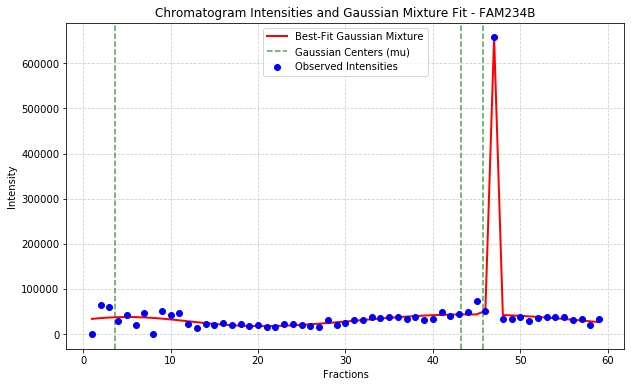

In [106]:
first_protein = list(prot_dict.keys())[5]
fractions = np.arange(1, len(prot_dict[first_protein]) + 1)
intensities = np.array(prot_dict[first_protein])

gmm = choose_gaussians(intensities, max_gaussians=5, filter_gaussians_height=0.05, filter_gaussians_variance_min=0)

# Call the function to visualize
visualize_fit(protein=first_protein, fractions=fractions, intensities=intensities, gmm=gmm)

In [107]:
intensities

array([5.38980331e+01, 6.46953477e+04, 6.03149922e+04, 2.84728379e+04,
       4.25807539e+04, 1.94752031e+04, 4.58186133e+04, 5.07486908e+02,
       5.19817344e+04, 4.12454141e+04, 4.71667422e+04, 2.14724531e+04,
       1.33648623e+04, 2.18209102e+04, 2.03974375e+04, 2.43170488e+04,
       2.08084238e+04, 2.27191152e+04, 1.84527012e+04, 1.94169531e+04,
       1.57461582e+04, 1.53638730e+04, 2.22701641e+04, 2.22192109e+04,
       2.01620039e+04, 1.80668008e+04, 1.46233682e+04, 3.15859629e+04,
       2.00769688e+04, 2.51856387e+04, 3.19685234e+04, 3.10577637e+04,
       3.82693242e+04, 3.64571719e+04, 3.82630703e+04, 3.83240469e+04,
       3.34663672e+04, 3.77555156e+04, 3.05116680e+04, 3.30224844e+04,
       4.94024102e+04, 4.03403984e+04, 4.53702969e+04, 4.85829648e+04,
       7.37112344e+04, 5.13950312e+04, 6.57178688e+05, 3.27002656e+04,
       3.30561562e+04, 3.72007656e+04, 2.77770332e+04, 3.54790039e+04,
       3.74965938e+04, 3.77640625e+04, 3.67023320e+04, 3.15625645e+04,
      

ignore_largest_residual works but I think it misses the point - with the current gaussian being fit, the overfit datapoint is not the largest residual anymore

In [103]:
gmm

{'R2': 0.9956550917314398,
 'coefs': {'A': array([0.46010946, 1.40404743, 1.00924962, 0.60354143, 0.12541176]),
  'mu': array([45.98969921,  2.42359723,  0.50017121, 50.86930592, 26.83543394]),
  'sigma': array([  3.0249096 ,   0.40840469,   1.81358427,  13.04476946,
         -13.75138131])},
 'fit_curve': array([0.93811454, 0.93911319, 0.99293   , 0.34873501, 0.03231757,
        0.01221946, 0.01273472, 0.01566822, 0.0192235 , 0.02334265,
        0.0280485 , 0.03335203, 0.03924675, 0.04570616, 0.05268216,
        0.06010451, 0.06788194, 0.0759049 , 0.08405022, 0.09218767,
        0.1001883 , 0.10793427, 0.11532978, 0.12231236, 0.1288639 ,
        0.1350205 , 0.14088018, 0.14660756, 0.15243474, 0.15865745,
        0.16562617, 0.17373188, 0.18338666, 0.19499956, 0.20894893,
        0.22555284, 0.24504339, 0.26757045, 0.29334653, 0.32327932,
        0.3607073 , 0.41418604, 0.49809673, 0.62415449, 0.78229426,
        0.92823859, 1.00312834, 0.97885738, 0.882607  , 0.77151213,
        0.687